In [1]:
import os
import sys
sys.path.append("/Users/williamjenkins/Research/Code/TritonOA/")

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.special import hankel1
from skopt.plots import plot_convergence, plot_gaussian_process, plot_objective
from skopt.space import Categorical, Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

from TritonOA.env import env
from TritonOA.io import readwrite
from TritonOA.plotting import plotting

### 0. Define Functions

In [2]:
def pressure_field(phi_src, phi_rec, k, r):
    p = (phi_src * phi_rec) @ hankel1(0, -k * r)
    p = np.pi * 1j / (1.) * p
    p = np.conj(p)
    return p


def bartlett(K, r_hat):
    w = r_hat / np.linalg.norm(r_hat)
    B = abs(w.conj().T @ K @ w)

    return float(B)








# def evaluate_kraken(sr, sd):
#     parameters = readwrite.pkl2dict(fname)
#     parameters['SD'] = sd
#     parameters['X'] = sr
    
#     ssp = env.SSPraw(
#         parameters['Z'],
#         parameters['CP'],
#         parameters['CS'],
#         parameters['RHO'],
#         parameters['AP'],
#         parameters['AS']
#     )

#     top = env.TopBndry(parameters['TOPOPT'])

#     halfspace = env.HS(
#         parameters['CPB'],
#         parameters['CSB'],
#         parameters['RHOB'],
#         parameters['APB'],
#         parameters['ASB']
#     )

#     bottom = env.BotBndry(parameters['BOTOPT'], halfspace)

#     bdy = env.Bndry(top, bottom)

#     depth = [0, parameters['ZB']]
#     ssp_list = [ssp]
#     NMESH = [parameters['NMESH']]
#     sigma = [parameters['SIGMA_TOP'], parameters['SIGMA_BOT']] # Roughness at each layer; only affects attenuation (imag. part)
#     ssp = env.SSP(
#         ssp_list,
#         depth,
#         parameters['NMEDIA'],
#         parameters['TOPOPT'],
#         NMESH,
#         sigma
#     )

#     cInt = env.cInt(parameters['CLOW'], parameters['CHIGH'])

# #     if parameters['fullfield']:
# #         parameters['X'] = np.arange(0, parameters['RMAX'], 0.001)
# #         r = env.Dom(parameters['X'], parameters['Z'])
# #     else:
# #         parameters['X'] = 5
# #         r = env.Dom(parameters['X'], parameters['RD'])

#     s = env.Source([parameters['SD']])
#     r = env.Dom(parameters['X'], parameters['RD'])
#     pos = env.Pos(s,r)
#     pos.Nsd = parameters['NSD']
#     pos.Nrd = parameters['NRD']

#     TITLE = "TestKraken"

#     readwrite.write_env(
#         f"{TITLE}.env",
#         "KRAKEN",
#         TITLE,
#         parameters['FREQ'],
#         ssp,
#         bdy,
#         pos,
#         [],
#         cInt,
#         parameters['RMAX']
#     )
#     os.system(f"kraken.exe {TITLE}")


#     options = {'fname': "TestKraken.mod", 'freq':0}
#     modes = readwrite.read_modes(**options)

#     k = modes.k
#     k = np.expand_dims(k, 1)

#     phi = modes.phi
#     mask = np.isclose(parameters['SD'], modes.z)
#     phi_src = phi[mask, :]
#     phi_rec = phi[np.invert(mask), :]

#     p = pressure_field(phi_src, phi_rec, k, pos.r.range * 1000)
    
#     return p, pos, modes


## 1. Define True Acoustic Field

### 1.1 Set Model Configuration

In [3]:
parameters = dict()

# Set Run Type ========================================================
parameters['fullfield'] = False
# Define Geometry ========================================================
parameters['NMEDIA'] = 1
parameters['ZB'] = 1000 # Bottom depth (m)
parameters['NZ'] = 1001 # Number of depth points
parameters['Z'] = np.linspace(0, parameters['ZB'], parameters['NZ']) # Depth vector (m)
parameters['RMAX'] = 10 # Maximum range (km)
# parameters['X'] = np.arange(0, parameters['RMAX'], 0.001)  # <-------------------------------- ***
parameters['NMESH'] = 0

# Define Top Boundary =========================================================
parameters['TOPOPT'] = "NVF" # C = Linear SSP interp; V = Vacuum in upper halfspace; F = Freq-dep Attenuation (dB/kmHz)
parameters['SIGMA_TOP'] = 0 # RMS roughness (m)

# Define Sound Speed Profile ================================================
SSP_TYPE = "isospeed"
[parameters.update({k: v}) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1500, dC=50).items()]

# Define Bottom Boundary ======================================================
parameters['BOTOPT'] = "A" # A = Acousto-elastic halfspace
parameters['SIGMA_BOT'] = 0 # RMS roughness (m)
parameters['CPB'] = 2000 # P-wave speed (m/s)
parameters['CSB'] = 0 # S-wave speed (m/s)
parameters['RHOB'] = 2.0 # Density (kg/m3)
parameters['APB'] = 0.2 # P-wave attenuation (dB/kmHz)
parameters['ASB'] = 0 # S-wave attenuation (dB/kmHz)

# Phase Speed Limits ============================================================
parameters['CLOW'] = 0 # Lower phase speed limit (m/s)
parameters['CHIGH'] = parameters['CPB']  # Upper phase speed limit (m/s)

# Define Source ============================================================
# parameters['SD'] = 25
# parameters['SR'] = 5
parameters['NSD'] = 1 
parameters['RD'] = np.arange(10, 110, 10)
parameters['NRD'] = len(parameters['RD'])
parameters['FREQ'] = 150

fname = 'parameters.p'
readwrite.dict2pkl(parameters, fname)

'parameters.p'

In [4]:
parameters['RD']

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

### 1.2 Run KRAKEN Propagation Model

In [5]:
sr = 5.3 # km
sd = 270 # m

p, pos, modes = evaluate_kraken(sr, sd)
np.save('received', p)

0


## 2. Estimate Acoustic Parameters

### 2.1 Define Parameter Space

In [ ]:
space = [
#     Real(0.5, 10, name='sr'),
    Real(0, parameters['ZB'], name='sd'),
]

@use_named_args(space)
def gp_loop(sr=5.3, sd=10):
    p_rec = np.load('received.npy')
    p_rep, _, _ = evaluate_kraken(sr, sd)
    B = bartlett(p_rec, p_rep)
    
#     loss = -np.log10(B)
    loss = 1 - np.log10(B)
    
    print('sr =', sr, 'sd =', sd, 'loss =', loss)

    return loss

### 2.2 Search for Optimal Parameters

In [ ]:
CALLS = 100

result_gp = gp_minimize(
    gp_loop,
    space,
    n_calls=CALLS,
    n_initial_points=100
)

In [ ]:
print(f'Range = {sr} km, Depth = {sd} m')

In [ ]:
plot_convergence(result_gp)
plot_objective(result_gp, n_points=100)

In [ ]:
# xy = np.asarray(result_gp.x_iters)
# x = xy[:,0]
# y = xy[:,1]
# f = np.asarray(result_gp.func_vals)
# plt.scatter(x, y, c=f)
# plt.scatter(sr, sd, c='r', marker='*')
# plt.xlabel('Range (km)')
# plt.ylabel('Depth (m)')

x = np.asarray(result_gp.x_iters)
y = np.asarray(result_gp.func_vals)
plt.scatter(x, y)
# plt.scatter(sr, sd, c='r', marker='*')
plt.xlabel('Depth (m)')
plt.ylabel('Loss')

0
sr = 3.701793635400527 sd = 948.4637838286445 loss = 2.1409695989412
0
sr = 1.1293365075993846 sd = 862.5438365362708 loss = 0.7345170302356117
0
sr = 5.402675570321069 sd = 974.6252740714012 loss = 1.3002097942700317
0
sr = 7.789563001471325 sd = 359.338585222211 loss = 1.600887410209225
0
sr = 3.175805309328581 sd = 987.4547606729514 loss = 1.1147414303613772
0
sr = 3.1025957471974364 sd = 933.2541143865548 loss = 0.876779237598269
0
sr = 1.3829736841136202 sd = 60.13483140836297 loss = 0.7532405663434343
0
sr = 3.6131719702306677 sd = 378.0035054482661 loss = 0.6809189367754076
0
sr = 2.892851929981208 sd = 956.038280586992 loss = 1.0230880307408263
0
sr = 7.423245402054585 sd = 295.41547117576624 loss = 0.5873680615412731
0
sr = 5.044967752046545 sd = 804.6534516593158 loss = 0.8384677516978307
0
sr = 1.903111900859154 sd = 603.1686761027236 loss = 0.7002382431196317
0
sr = 4.405289763972607 sd = 555.0333025143193 loss = 0.9064805955644193
0
sr = 6.341228725381281 sd = 938.242357

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0
sr = 0.5 sd = 1000.0 loss = 1.3262633018719896
0
sr = 3.101381381457789 sd = 128.94614479830315 loss = 0.9523993197733027
0
sr = 8.632744798591471 sd = 857.4696554665396 loss = 0.8637719445403444
0
sr = 7.7129666028459924 sd = 866.6708485765602 loss = 1.6587069102728886
0
sr = 1.7428888175834278 sd = 791.0271862152138 loss = 2.026640719873292
0
sr = 9.961056664590256 sd = 7.2743906113257335 loss = 1.3470800173957471
0
sr = 9.973643475331261 sd = 994.4767235726829 loss = 1.622365237620766
0
sr = 9.91251316372599 sd = 5.738111874126429 loss = 1.7925462160319867
0
sr = 0.5070591513692989 sd = 994.8979089444574 loss = 1.3299407034772344
0
sr = 9.932898807609869 sd = 1.8750797255054912 loss = 0.6432733722591699
0
sr = 0.5264774343852073 sd = 998.3883552694745 loss = 1.313933641512607
0
sr = 9.98566228429998 sd = 999.2487830398492 loss = 1.406637858340158
0
sr = 9.957976924013277 sd = 8.164466942035766 loss = 1.8404846364691902
0
sr = 0.5116319914714476 sd = 7.258878389820646 loss = 1.6079

array([[<AxesSubplot:xlabel='sr', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='sr', ylabel='sd'>,
        <AxesSubplot:xlabel='sd', ylabel='Partial dependence'>]],
      dtype=object)

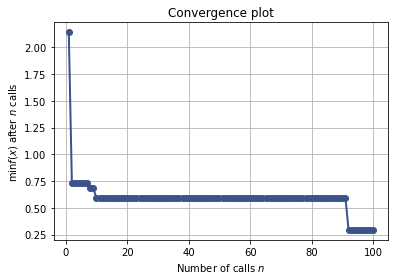

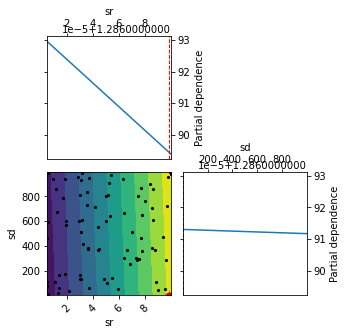

In [8]:
space = [
    Real(0.5, parameters['RMAX'], name='sr'),
    Real(0, parameters['ZB'], name='sd'),
]

@use_named_args(space)
def gp_loop(sr=1, sd=10):
    p_rec = np.load('received.npy')
    p_rep, _, _ = evaluate_kraken(sr, sd)
    B = bartlett(p_rec, p_rep)
    
    loss = 10 - np.log10(B)
    
    print('sr =', sr, 'sd =', sd, 'loss =', loss)

    return loss

CALLS = 100

result_gp = gp_minimize(
    gp_loop,
    space,
    n_calls=CALLS,
    n_initial_points=50,
    random_state=2009,
    n_jobs=-1
)

plot_convergence(result_gp)
plot_objective(result_gp, n_points=100)

## 3. Compare to Matched Field Processing

Before searching for the optimal acoustic parameters, perform matched field processing (MFP) to obtain the Bartlett output for every point in the depth-range grid in 1x1 m resolution.

In [ ]:
ranges = np.linspace(0, parameters['RMAX'], 10001)
depths = np.linspace(0, parameters['ZB'], 1001)

B = np.zeros((len(depths), len(ranges)))

for zz, sd in enumerate(depths):
    for rr, sr in enumerate(ranges):
        p_rec = np.load('received.npy')
        p_rep, _, _, = evaluate_kraken(sr, sd)
        B[zz, rr] = bartlett(p_rec, p_rep)


